# 开发 AI 应用

未来，AI 算法在日常生活中的应用将越来越广泛。例如，你可能想要在智能手机应用中包含图像分类器。为此，在整个应用架构中，你将使用一个用成百上千个图像训练过的深度学习模型。未来的软件开发很大一部分将是使用这些模型作为应用的常用部分。

在此项目中，你将训练一个图像分类器来识别不同的花卉品种。可以想象有这么一款手机应用，当你对着花卉拍摄时，它能够告诉你这朵花的名称。在实际操作中，你会训练此分类器，然后导出它以用在你的应用中。我们将使用[此数据集](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)，其中包含 102 个花卉类别。你可以在下面查看几个示例。 

<img src='assets/Flowers.png' width=500px>

该项目分为多个步骤：

* 加载和预处理图像数据集
* 用数据集训练图像分类器
* 使用训练的分类器预测图像内容

我们将指导你完成每一步，你将用 Python 实现这些步骤。

完成此项目后，你将拥有一个可以用任何带标签图像的数据集进行训练的应用。你的网络将学习花卉，并成为一个命令行应用。但是，你对新技能的应用取决于你的想象力和构建数据集的精力。例如，想象有一款应用能够拍摄汽车，告诉你汽车的制造商和型号，然后查询关于该汽车的信息。构建你自己的数据集并开发一款新型应用吧。

首先，导入你所需的软件包。建议在代码开头导入所有软件包。当你创建此 notebook 时，如果发现你需要导入某个软件包，确保在开头导入该软件包。

In [33]:
# Imports here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms, datasets
import os
import torch.utils
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import copy
from torch.autograd import Variable
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))

pytorch version: 0.4.1


## 加载数据

在此项目中，你将使用 `torchvision` 加载数据（[文档](http://pytorch.org/docs/master/torchvision/transforms.html#)）。数据应该和此 notebook 一起包含在内，否则你可以[在此处下载数据](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)。数据集分成了三部分：训练集、验证集和测试集。对于训练集，你需要变换数据，例如随机缩放、剪裁和翻转。这样有助于网络泛化，并带来更好的效果。你还需要确保将输入数据的大小调整为 224x224 像素，因为预训练的网络需要这么做。

验证集和测试集用于衡量模型对尚未见过的数据的预测效果。对此步骤，你不需要进行任何缩放或旋转变换，但是需要将图像剪裁到合适的大小。

对于所有三个数据集，你都需要将均值和标准差标准化到网络期望的结果。均值为 `[0.485, 0.456, 0.406]`，标准差为 `[0.229, 0.224, 0.225]`。这样使得每个颜色通道的值位于 -1 到 1 之间，而不是 0 到 1 之间。

In [2]:
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'
data_dir = 'flowers'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}


# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) for x in ['train', 'valid', 'test']}

class_indexes = image_datasets['train'].class_to_idx
print('number of classes:{}'.format(len(class_indexes)))

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) 
               for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

number of classes:102
device: cuda:0


### 标签映射

你还需要加载从类别标签到类别名称的映射。你可以在文件 `cat_to_name.json` 中找到此映射。它是一个 JSON 对象，可以使用 [`json` 模块](https://docs.python.org/2/library/json.html)读取它。这样可以获得一个从整数编码的类别到实际花卉名称的映射字典。

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 构建和训练分类器

数据准备好后，就开始构建和训练分类器了。和往常一样，你应该使用 `torchvision.models` 中的某个预训练模型获取图像特征。使用这些特征构建和训练新的前馈分类器。

这部分将由你来完成。如果你想与他人讨论这部分，欢迎与你的同学讨论！你还可以在论坛上提问或在工作时间内咨询我们的课程经理和助教导师。

请参阅[审阅标准](https://review.udacity.com/#!/rubrics/1663/view)，了解如何成功地完成此部分。你需要执行以下操作：

* 加载[预训练的网络](http://pytorch.org/docs/master/torchvision/models.html)（如果你需要一个起点，推荐使用 VGG 网络，它简单易用）
* 使用 ReLU 激活函数和丢弃定义新的未训练前馈网络作为分类器
* 使用反向传播训练分类器层，并使用预训练的网络获取特征
* 跟踪验证集的损失和准确率，以确定最佳超参数

我们在下面为你留了一个空的单元格，但是你可以使用多个单元格。建议将问题拆分为更小的部分，并单独运行。检查确保每部分都达到预期效果，然后再完成下个部分。你可能会发现，当你实现每部分时，可能需要回去修改之前的代码，这很正常！

训练时，确保仅更新前馈网络的权重。如果一切构建正确的话，验证准确率应该能够超过 70%。确保尝试不同的超参数（学习速率、分类器中的单元、周期等），寻找最佳模型。保存这些超参数并用作项目下个部分的默认值。

In [5]:
# TODO: Build and train your network
# 导出特征向量
# 模型：Densenet-121，ResNet-18，VGG-19
vgg19 = models.vgg19(pretrained=True)
class VGG19FineTune(nn.Module):
    def __init__(self):
        super(VGG19FineTune, self).__init__()
        self.features = vgg19.features
        for param in self.parameters():
            param.requires_grad = False
        # only change classifer layer
        self.classifers = nn.Sequential(
            *list(vgg19.classifier.children())[:-1], 
            nn.Linear(in_features=4096, out_features=len(image_datasets['train'].classes), bias=True))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifers(x)
        return x

vgg19Tune = VGG19FineTune()
# print(vgg19Tune)

In [6]:
resnet50 = models.resnet50(pretrained=True)
class Resnet50FineTune(nn.Module):
    def __init__(self):
        super(Resnet50FineTune, self).__init__()
        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        for param in self.parameters():
            param.require_grad = False
        # only change classifer layer
        self.classifiers = nn.Linear(in_features=2048, out_features=len(image_datasets['train'].classes), bias=True)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifiers(x)
        return x

resnet50Tune = Resnet50FineTune()
# print(resnet50Tune)

In [7]:
densenet121 = models.densenet121(pretrained=True)
class Densenet121FineTune(nn.Module):
    def __init__(self):
        super(Densenet121FineTune, self).__init__()
        self.features = densenet121.features
        for param in self.parameters():
            param.require_grad = False
        # only change classifer layer
        self.classifiers = nn.Linear(in_features=1024, out_features=len(image_datasets['train'].classes), bias=True)
    def forward(self, x):
        # copy from Densenet implementation in pytorch/vision
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
        out = self.classifiers(out)
        return out

densenet121Tune = Densenet121FineTune()
# print(densenet121Tune)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [8]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print_every = 3
    
    for epoch in range(num_epochs):
        print('epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = Variable(inputs)
                labels = Variable(labels)
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        print()
    
    print('best acc {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_weights)
    return model

In [9]:
# fine-tuning vgg model
vgg19Tune.cuda()
criterion = CrossEntropyLoss()
optimizer = optim.SGD(vgg19Tune.classifers.parameters(), lr=0.01, momentum=0.9)
vgg19TuneBest = train_model(vgg19Tune, criterion, optimizer)

epoch 0/24
----------
train loss: 2.2922 acc: 0.4469
valid loss: 1.2472 acc: 0.6601

epoch 1/24
----------
train loss: 1.2694 acc: 0.6685
valid loss: 1.0699 acc: 0.7054

epoch 2/24
----------
train loss: 1.0704 acc: 0.7074
valid loss: 0.9288 acc: 0.7408

epoch 3/24
----------
train loss: 0.9940 acc: 0.7215
valid loss: 0.8740 acc: 0.7567

epoch 4/24
----------
train loss: 0.8964 acc: 0.7543
valid loss: 0.8171 acc: 0.7800

epoch 5/24
----------
train loss: 0.8426 acc: 0.7674
valid loss: 0.8264 acc: 0.7726

epoch 6/24
----------
train loss: 0.7908 acc: 0.7811
valid loss: 0.7643 acc: 0.7897

epoch 7/24
----------
train loss: 0.7617 acc: 0.7819
valid loss: 0.8179 acc: 0.7787

epoch 8/24
----------
train loss: 0.7159 acc: 0.7999
valid loss: 0.7677 acc: 0.7861

epoch 9/24
----------
train loss: 0.7561 acc: 0.7908
valid loss: 0.7491 acc: 0.7971

epoch 10/24
----------
train loss: 0.6905 acc: 0.8028
valid loss: 0.7293 acc: 0.8081

epoch 11/24
----------
train loss: 0.6681 acc: 0.8167
valid loss

In [10]:
# fine-tuning resnet model 
resnet50Tune.cuda()
criterion = CrossEntropyLoss()
optimizer = optim.SGD(resnet50Tune.classifiers.parameters(), lr=0.01, momentum=0.9)
resnet50TuneBest = train_model(resnet50Tune, criterion, optimizer)

epoch 0/24
----------
train loss: 2.9398 acc: 0.4055
valid loss: 1.8984 acc: 0.6112

epoch 1/24
----------
train loss: 1.2620 acc: 0.7712
valid loss: 1.1981 acc: 0.7751

epoch 2/24
----------
train loss: 0.8758 acc: 0.8405
valid loss: 0.9633 acc: 0.8081

epoch 3/24
----------
train loss: 0.6812 acc: 0.8726
valid loss: 0.8743 acc: 0.8215

epoch 4/24
----------
train loss: 0.5955 acc: 0.8878
valid loss: 0.7927 acc: 0.8337

epoch 5/24
----------
train loss: 0.5302 acc: 0.8973
valid loss: 0.7719 acc: 0.8337

epoch 6/24
----------
train loss: 0.4988 acc: 0.8999
valid loss: 0.7454 acc: 0.8350

epoch 7/24
----------
train loss: 0.4623 acc: 0.9063
valid loss: 0.6821 acc: 0.8509

epoch 8/24
----------
train loss: 0.4163 acc: 0.9158
valid loss: 0.6735 acc: 0.8411

epoch 9/24
----------
train loss: 0.4015 acc: 0.9180
valid loss: 0.6349 acc: 0.8496

epoch 10/24
----------
train loss: 0.3903 acc: 0.9209
valid loss: 0.6148 acc: 0.8496

epoch 11/24
----------
train loss: 0.3805 acc: 0.9170
valid loss

In [11]:
densenet121Tune.cuda()
criterion = CrossEntropyLoss()
optimizer = optim.SGD(densenet121Tune.classifiers.parameters(), lr=0.01, momentum=0.9)
densenet121TuneBest = train_model(densenet121Tune, criterion, optimizer)

epoch 0/24
----------
train loss: 2.8114 acc: 0.4408
valid loss: 1.7365 acc: 0.6907

epoch 1/24
----------
train loss: 1.1170 acc: 0.8057
valid loss: 1.1418 acc: 0.7836

epoch 2/24
----------
train loss: 0.7441 acc: 0.8698
valid loss: 0.9398 acc: 0.8068

epoch 3/24
----------
train loss: 0.6044 acc: 0.8906
valid loss: 0.8321 acc: 0.8117

epoch 4/24
----------
train loss: 0.5148 acc: 0.9034
valid loss: 0.7699 acc: 0.8276

epoch 5/24
----------
train loss: 0.4682 acc: 0.9112
valid loss: 0.7141 acc: 0.8325

epoch 6/24
----------
train loss: 0.4299 acc: 0.9113
valid loss: 0.6993 acc: 0.8460

epoch 7/24
----------
train loss: 0.3928 acc: 0.9225
valid loss: 0.6433 acc: 0.8496

epoch 8/24
----------
train loss: 0.3670 acc: 0.9278
valid loss: 0.6287 acc: 0.8460

epoch 9/24
----------
train loss: 0.3693 acc: 0.9222
valid loss: 0.6125 acc: 0.8606

epoch 10/24
----------
train loss: 0.3403 acc: 0.9284
valid loss: 0.5959 acc: 0.8472

epoch 11/24
----------
train loss: 0.3289 acc: 0.9309
valid loss

## 测试网络

建议使用网络在训练或验证过程中从未见过的测试数据测试训练的网络。这样，可以很好地判断模型预测全新图像的效果。用网络预测测试图像，并测量准确率，就像验证过程一样。如果模型训练良好的话，你应该能够达到大约 70% 的准确率。

In [9]:
def test_model(model, criterion):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
            
    for inputs, labels in dataloaders['test']:
        inputs = Variable(inputs)
        labels = Variable(labels)
                
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']
    print('test loss: {:.4f} acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [15]:
# TODO: Do validation on the test set
test_model(vgg19TuneBest, criterion)

test loss: 0.7380 acc: 0.7827


In [16]:
test_model(resnet50TuneBest, criterion)

test loss: 0.5180 acc: 0.8669


In [43]:
test_model(densenet121TuneBest, criterion)

test loss: 0.4922 acc: 0.8669


通过在测试集上测试三个预训练模型发现相比之下Densenet121的性能要好一些，因此决定选用该模型来完成剩下的任务。

## 保存检查点

训练好网络后，保存模型，以便稍后加载它并进行预测。你可能还需要保存其他内容，例如从类别到索引的映射，索引是从某个图像数据集中获取的：`image_datasets['train'].class_to_idx`。你可以将其作为属性附加到模型上，这样稍后推理会更轻松。

注意，稍后你需要完全重新构建模型，以便用模型进行推理。确保在检查点中包含你所需的任何信息。如果你想加载模型并继续训练，则需要保存周期数量和优化器状态 `optimizer.state_dict`。你可能需要在下面的下个部分使用训练的模型，因此建议立即保存它。

In [19]:
# TODO: Save the checkpoint
checkpoint = {
    'vgg19': vgg19TuneBest.state_dict(),
    'resnet50': resnet50TuneBest.state_dict(),
    'densenet': densenet121TuneBest.state_dict(),
    'class_to_idx': image_datasets['train'].class_to_idx,
}

torch.save(checkpoint, 'checkpoint.pth')

## 加载检查点

此刻，建议写一个可以加载检查点并重新构建模型的函数。这样的话，你可以回到此项目并继续完善它，而不用重新训练网络。

In [10]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def rebuild_model(model_name):
    checkpoint = torch.load('checkpoint.pth')
    if model_name == 'vgg19':
        model = VGG19FineTune()
        model.load_state_dict(checkpoint['vgg19'])
    elif model_name == 'resnet50':
        model = Resnet50FineTune()
        model.load_state_dict(checkpoint['resnet50'])
    elif model_name == 'densenet':
        model = Densenet121FineTune()
        model.load_state_dict(checkpoint['densenet'])
    class_to_idx = checkpoint['class_to_idx']
    return model, class_to_idx

In [11]:
dense_model, class_to_idx = rebuild_model('densenet')

# 类别推理

现在，你需要写一个使用训练的网络进行推理的函数。即你将向网络中传入一个图像，并预测图像中的花卉类别。写一个叫做 `predict` 的函数，该函数会接受图像和模型，然后返回概率在前 $K$ 的类别及其概率。应该如下所示：

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

首先，你需要处理输入图像，使其可以用于你的网络。

## 图像处理

你需要使用 `PIL` 加载图像（[文档](https://pillow.readthedocs.io/en/latest/reference/Image.html)）。建议写一个函数来处理图像，使图像可以作为模型的输入。该函数应该按照训练的相同方式处理图像。

首先，调整图像大小，使最小的边为 256 像素，并保持宽高比。为此，可以使用 [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 或 [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 方法。然后，你需要从图像的中心裁剪出 224x224 的部分。

图像的颜色通道通常编码为整数 0-255，但是该模型要求值为浮点数 0-1。你需要变换值。使用 Numpy 数组最简单，你可以从 PIL 图像中获取，例如 `np_image = np.array(pil_image)`。

和之前一样，网络要求图像按照特定的方式标准化。均值应标准化为 `[0.485, 0.456, 0.406]`，标准差应标准化为 `[0.229, 0.224, 0.225]`。你需要用每个颜色通道减去均值，然后除以标准差。

最后，PyTorch 要求颜色通道为第一个维度，但是在 PIL 图像和 Numpy 数组中是第三个维度。你可以使用 [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html)对维度重新排序。颜色通道必须是第一个维度，并保持另外两个维度的顺序。

In [20]:
from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    w, h = image.size
    if w <= h:
        h = int(256 * h / w)
        w = 256
    else:
        w = int(256 * w / h)
        h = 256
    im = image.resize((w, h))
    w, h = im.size
    nw, nh = 224, 224
    left = (w - nw) / 2
    top = (h - nh) / 2
    right = (w + nw) / 2
    down = (h + nh) / 2
    im = im.crop((left, top, right, down))
    np_im = np.array(im)
    np_im = np_im / 255
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    np_im = (np_im - means) / stds
    return torch.from_numpy(np_im.transpose(2, 0, 1))

In [13]:
def process_image2(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    img_transforms = transforms.Compose([transforms.Scale(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225]),
                                         
                                        ])
    img_tensor = img_transforms(im)
    return img_tensor

要检查你的项目，可以使用以下函数来转换 PyTorch 张量并将其显示在  notebook 中。如果 `process_image` 函数可行，用该函数运行输出应该会返回原始图像（但是剪裁掉的部分除外）。

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

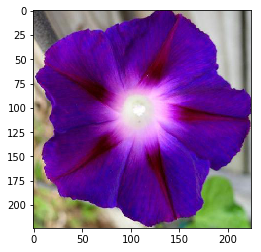

In [21]:
image = Image.open('flowers/train/76/image_02447.jpg')
im = process_image(image)
imshow(im)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


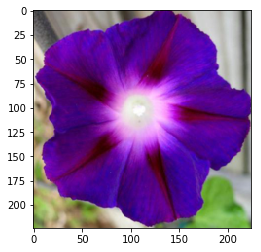

In [22]:
image = Image.open('flowers/train/76/image_02447.jpg')
im = process_image2('flowers/train/76/image_02447.jpg')
imshow(im)

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [23]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    im = Image.open(image_path)
    im = process_image(im)
    im = im.view(1, *im.shape)
    model.eval()
    output = model(im.float())
    output = F.softmax(output)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    probs, indices = output.topk(topk)
    indices = indices[0]
    classes = [idx_to_class[index.item()] for index in indices]
    return probs.data.numpy()[0], classes

## 检查运行状况

你已经可以使用训练的模型做出预测，现在检查模型的性能如何。即使测试准确率很高，始终有必要检查是否存在明显的错误。使用 `matplotlib` 将前 5 个类别的概率以及输入图像绘制为条形图，应该如下所示：

<img src='assets/inference_example.png' width=300px>

你可以使用 `cat_to_name.json` 文件（应该之前已经在 notebook 中加载该文件）将类别整数编码转换为实际花卉名称。要将 PyTorch 张量显示为图像，请使用定义如下的 `imshow` 函数。

In [31]:
# TODO: Display an image along with the top 5 classes
values, classes = predict('flowers/test/36/image_04382.jpg', dense_model)
flowers = [cat_to_name[cls] for cls in classes]
print(values)
print(classes)
print(flowers)

[9.9969578e-01 1.8172462e-04 2.8519977e-05 2.2745482e-05 2.0803431e-05]
['36', '91', '43', '67', '7']
['ruby-lipped cattleya', 'hippeastrum', 'sword lily', 'spring crocus', 'moon orchid']


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


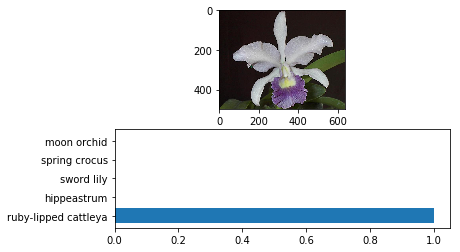

In [44]:
plt.subplot(2, 1, 1)
image = Image.open('flowers/test/36/image_04382.jpg')
plt.imshow(image)

df = pd.DataFrame(dict(probs=values, flowers=flowers))
plt.subplot(2, 1, 2)
plt.barh(df.flowers, df.probs);